In [69]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import fiona
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd

In [68]:
# 1. Load county air pollutant data from EPA, per https://www.epa.gov/air-trends/air-quality-cities-and-counties
county_data = pd.read_excel('AirQuality_by_County.xlsx', dtype=dtype_mapping)


# 2. Load cigarette smoking data from CDC, per https://www.cdc.gov/tobacco/data_statistics/fact_sheets/adult_data/cig_smoking/index.htm
smoking_data = pd.read_csv('smoking_data.csv')

# Capitalize state names for ease in merging later
smoking_data['Location'] = smoking_data['Location'].str.upper()


# 3. Load Cause of Death (CoD) data from National Vital Statistics System (NVSS), per https://www.cdc.gov/nchs/data-visualization/mortality-leading-causes/
CoD = pd.read_csv('US_COD_data.csv')
CoD['State'] = CoD['State'].str.upper()

# Filter for most recent respiratory illness death rates
CoD = CoD[(CoD['Cause Name'] == 'CLRD') & (CoD['Year'] == 2017)]

In [3]:
# Load county shapefile from the US Census Bureau
counties_shp = fiona.open('Counties.shp')
counties_shp_shp = gpd.read_file('USA_Counties_(Generalized).shp')
counties_shp_shp = counties_shp_shp.sort_values(by='POP_SQMI', ascending=False)

# Load state shapefile from the US Census Bureau
states_shp = fiona.open('States_shapefile.shp')
states_shp_shp = gpd.read_file('States_shapefile.shp')


In [ ]:
# Data preprocessing and cleaning
county_data['County FIPS Code'] = county_data['County FIPS Code'].astype(str)
county_data['County FIPS Code'] = county_data['County FIPS Code'].fillna('Unknown')

# Create attribute DataFrames
attribute_df = pd.DataFrame(columns=counties_shp.schema['properties'].keys())
for feature in counties_shp:
    attributes = feature['properties']
    attribute_df = attribute_df.append(attributes, ignore_index=True)

state_df = pd.DataFrame(columns=states_shp.schema['properties'].keys())
for feature in states_shp:
    attributes = feature['properties']
    state_df = state_df.append(attributes, ignore_index=True)

In [6]:
# Merge county pollutant data with shapefile based on County FIPS Code
merged_county_data = attribute_df.merge(county_data, left_on='FIPS', right_on='County FIPS Code', how='left')
merged_county_data['O3            8-hr (ppm)'] = merged_county_data['O3            8-hr (ppm)'].replace('ND', np.nan)
merged_county_data = merged_county_data.dropna(subset=['O3            8-hr (ppm)'], axis=0)
merged_county_data.reset_index(drop=True, inplace=True)

In [52]:
# Merge state shapefile dataframe data with CoD data based on state name
merged_state_data = states_shp_shp.merge(CoD, left_on='State_Name', right_on='State', how='left')
merged_state_data['Age-adjusted Death Rate'] = merged_state_data['Age-adjusted Death Rate'].replace('ND', np.nan)
merged_state_data = merged_state_data.dropna(subset=['Age-adjusted Death Rate'], axis=0)
merged_state_data.reset_index(drop=True, inplace=True)
merged_state_data['Age-adjusted Death Rate'] = pd.to_numeric(merged_state_data['Age-adjusted Death Rate'], errors='coerce') #converting to numeric for proper visualization later

In [44]:
# Merge state data with smoking data
merged_smoking_data = states_shp_shp.merge(smoking_data, left_on='State_Name', right_on='Location', how='left')
merged_smoking_data.reset_index(drop=True, inplace=True)

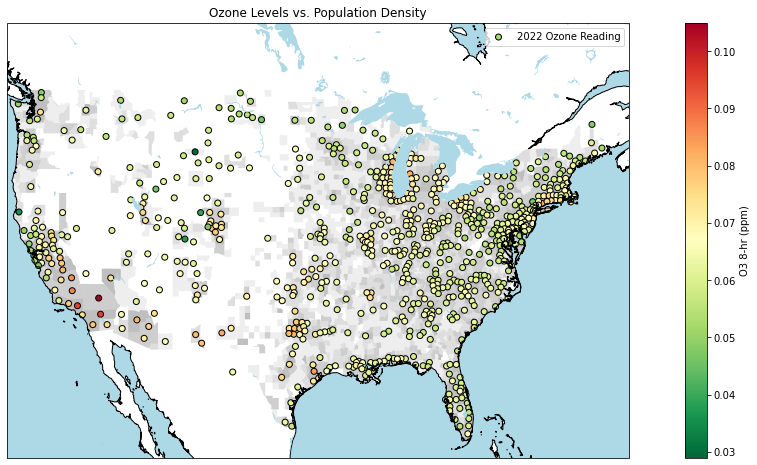

In [63]:
# Create a new figure for the first plot visualizing population density compared with ozone pollution
fig = plt.figure(figsize=(20, 8))

# Create an axes object for the map projection using Plate Carrée projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the geographic extent for the map by specifying the longitude and latitude range of the continental US.
ax.set_extent([-125, -65, 24, 50])

# Plot the data from county shapefile on the map, colorized based on population density
counties_shp_shp.plot(
    column='POP_SQMI', 
    cmap='gray_r', 
    ax=ax, 
    linewidth=0, 
    edgecolor='0.99', 
    legend=True, 
    scheme='quantiles', 
    alpha=0.25) #Transparency to improve visual appearance

# Create a scatter plot on the map to visualize ozone readings for different monitoring locations, placed on the centroid of the county
sc = ax.scatter(
    merged_county_data['CENTROID_X'], 
    merged_county_data['CENTROID_Y'], 
    marker='o', 
    c=merged_county_data['O3            8-hr (ppm)'], 
    cmap='RdYlGn_r', 
    edgecolor='black', 
    label='2022 Ozone Reading')

# Add a color bar to the plot, labeling the color scale as 'Ozone (ppm)'
plt.colorbar(sc, label='Ozone (ppm)')

# Add water features and coastlines to the map 
ax.coastlines(resolution='10m')
ax.add_feature(cf.LAKES, edgecolor='none', facecolor='lightblue')
ax.add_feature(cf.OCEAN, edgecolor='none', facecolor='lightblue')

# Add a title and legend
plt.title('Ozone Levels vs. Population Density')
plt.legend()

# Show the map
plt.show()

This preliminary analysis and comparison of two datasets reveals an important logical trend: air quality is inversely correllated with population density. Ozone, one of the most harmful pollutants to human respiratory systems, is clearly observed in higher concentrations in high population urban centers. For example, large cities such as Los Angeles and New York are are clearly represented by orange and red markers indicated elevated ozone levels. 

With this correllation in mind, I was curious if these pollutant levels significantly impacted respiratory illness rates in these areas. In the following map, government data regarding death rates by respiratory illness is visualized and compared with these same ozone readings. The interesting, significant trends revealed in this map and the subsequent maps demonstrate the power of geospatial data analysis.

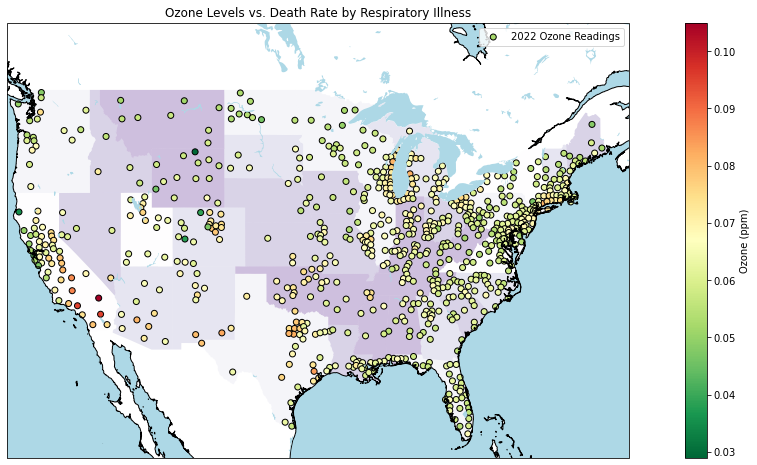

In [65]:
# Create a new figure for the second plot visualizing respiratory illess rates compared with ozone pollution 
fig2 = plt.figure(figsize=(20, 8))

# Create an axes object for the map projection using Plate Carrée projection
ax2 = plt.axes(projection=ccrs.PlateCarree())

# Set the geographic extent for the map by specifying the longitude and latitude range of the continental US.
ax2.set_extent([-125, -65, 24, 50])

# Plot the data from 'merged_state_data' on the map, colorizing the US states shapefile based on the age-adjusted death rate of respiratory illness
merged_state_data.plot(
    column='Age-adjusted Death Rate',
    cmap='Purples',
    ax=ax2,
    linewidth=0,
    edgecolor='0.99',
    legend=True,
    scheme='quantiles',
    alpha=0.25
)

# Create a scatter plot on the map to visualize ozone readings for different monitoring locations, placed on the centroid of the county
sc = ax2.scatter(
    merged_county_data['CENTROID_X'],
    merged_county_data['CENTROID_Y'],
    marker='o',
    c=merged_county_data['O3            8-hr (ppm)'],
    cmap='RdYlGn_r',
    edgecolor='black',
    label='2022 Ozone Readings'
)

# Add a color bar to the plot, labeling the color scale as 'Ozone (ppm)'
plt.colorbar(sc, label='Ozone (ppm)')

# Add water features and coastlines to the map 
ax2.coastlines(resolution='10m')
ax2.add_feature(cf.LAKES, edgecolor='none', facecolor='lightblue')
ax2.add_feature(cf.OCEAN, edgecolor='none', facecolor='lightblue')

# Add a title and legend
plt.title('Ozone Levels vs. Death Rate by Respiratory Illness')
plt.legend()

Here, we see less of a trend emerge. In fact, the areas mentioned in the previous comparison, NYC and LA, now appear to have an inverse correlation, if any, with respiratory illness. This was unexpected yet intriguing. Clearly, although harmful, ozone and air pollution at large do not appear to be a significant cause of respiratory illness at the levels found in the continental United States. 

This left me to wonder, what **is** a major contributing factor to respiratory illness in more these rural areas with higher rates? A clear frontrunner for a potential cause was obvious: cigarette smoking. I located state level data from the CDC that lists the average smoking rate among adults in each state and merged it with my existing state shapefile from the Census Bureau. In the following maps, I compare the the frequency of smoking with death rate by respiratory illness to see if any trends became apparent.

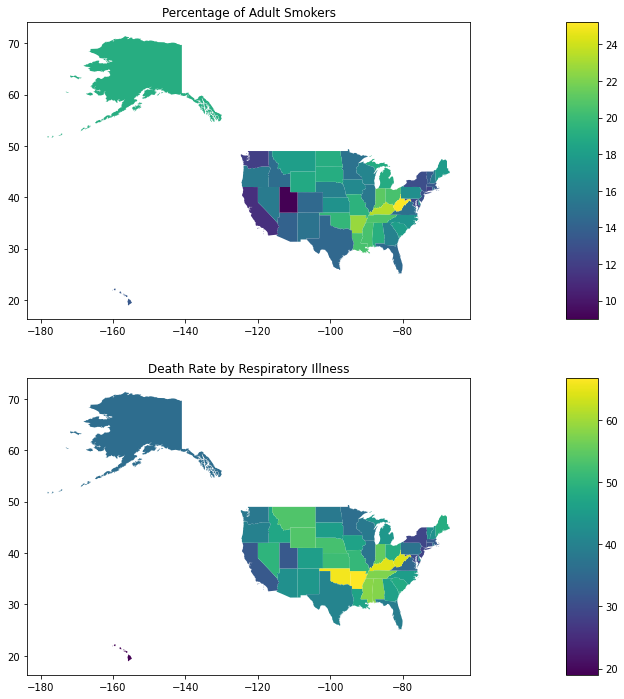

In [66]:
# Create a subplot with 2 rows and 1 column for stacked maps to compare two different state level datasets
fig3, axes = plt.subplots(2, 1, figsize=(45, 12))

# Create a divider and colorbar for the first subplot
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)

# Create a divider and colorbar for the second subplot
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)

# Plot the first map based on 'Data_Value' attribute, which represents the percentage of adults who smoke cigarettes
merged_smoking_data.plot(column='Data_Value', cmap='viridis', ax=axes[0], legend=True, cax=cax1)

# Set the title for the first map
axes[0].set_title('Percentage of Adult Smokers')

# Plot the second map based on 'Age-adjusted Death Rate' attribute, which represents the age-adjusted death rate by respiratory illness
merged_state_data.plot(column='Age-adjusted Death Rate', cmap='viridis', ax=axes[1], legend=True, cax=cax2)

# Set the title for the second map
axes[1].set_title('Death Rate by Respiratory Illness')

# Show the maps
plt.show()

The correllation here is obvious and definitive. States with high smoking rates possess high respiratory illness death rates as well, regardless of air quality, ozone levels, or population density. This exercise in data acquisition, processing, and visualization clearly demonstrates the importance and efficiency of geospatial data science for identifying spatial trends. While I originally sought to identify a correllation between air quality and respiratory illness, I was able to quickly visualize the contents of vast geospatial datasets to identify accurate trends and draw important conclusions.